In [1]:
#before proceeding you should run these in your python: 
#---------------------------------------------------------------------------------------------------
# pip install openmeteo-requests 
# pip install requests-cache retry-requests numpy pandas

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import scipy.stats as stats
import os
import numpy as np
import json
import requests
from pprint import pprint
from retry_requests import retry
import requests_cache
import openmeteo_requests

In [4]:
with open('descriptions.json', 'r') as f:
    data = json.load(f)
# Accessing data
code = ['weather_code']

#data[code]['day']["description"]
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 39.0376,
	"longitude": -77.4158,
	"start_date": "2000-01-01",
	"end_date": "2008-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "weather_code", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"],
	"daily": "weather_code",
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch",
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(7).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(8).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(9).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(10).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(11).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(12).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(13).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(14).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(15).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(16).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(17).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(18).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["weather_code"] = hourly_weather_code.astype(int)
hourly_data["pressure_msl"] = hourly_pressure_msl
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
#print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code

daily_dataframe = pd.DataFrame(data = daily_data)
hourly_dataframe.head()

Coordinates 39.05096435546875°N -77.40740966796875°E
Elevation 101.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
0,2000-01-01 04:00:00+00:00,36.844700,84.508644,31.711010,0.0,0.0,0.0,0.0,0,1022.900024,1010.199524,0.0,0.0,0.0,0.0,3.325540,4.161060,250.346085,216.253922,3.8029
1,2000-01-01 05:00:00+00:00,36.214699,84.774651,30.907288,0.0,0.0,0.0,0.0,0,1022.799988,1010.084900,0.0,0.0,0.0,0.0,3.537008,4.803042,251.564957,207.758453,3.8029
2,2000-01-01 06:00:00+00:00,36.034698,84.456161,30.554066,0.0,0.0,0.0,0.0,0,1023.000000,1010.277649,0.0,0.0,0.0,0.0,3.848680,6.085298,234.462234,197.102814,4.6977
3,2000-01-01 07:00:00+00:00,32.704700,90.322327,26.706497,0.0,0.0,0.0,0.0,0,1022.700012,1009.896057,0.0,0.0,0.0,0.0,4.501876,8.325127,206.564987,186.170074,6.9347
4,2000-01-01 08:00:00+00:00,30.364700,93.612801,24.137669,0.0,0.0,0.0,0.0,0,1023.099976,1010.230469,0.0,0.0,0.0,0.0,4.562603,10.997762,191.309891,184.666779,7.3821


In [5]:
#This will change the weather code in (hourly_dataframe, cell above this) with what the weather actually was. Then condense the file to have fewer columns. 
#This will take approximately 5:30 seconds to complete. I saved it to a CSV file so that i don't need to run it every time.
#----------------------------------------------------------------------------------------------------------------------------------------------------------
clean_data = hourly_dataframe.rename(columns={'date': "Date", 'relative_humidity_2m':"Relative Humidity", 'wind_speed_100m': "Wind Speed at 100m",'wind_speed_10m': "Wind Speed at 10m",'wind_gusts_10m': "Wind Gusts at 10m",'apparent_temperature':"Temperature",'precipitation': "Precipitation",'rain':"Rain Fall",'snowfall': "Snow Fall",'snow_depth':"Amount of Snow",'weather_code':"Weather"})
#clean_data = clean_data[['Date','Temperature','Precipitation', 'Rain Fall', 'Snow Fall', 'Amount of Snow', 'Weather']]
clean_data = pd.DataFrame(clean_data)


def weather(code):
    with open('descriptions.json', 'r') as f:
        data = json.load(f)
    code = f"{code}"
    data=data[code]['day']["description"]
    return data
for code in clean_data['Weather']:
    data = weather(code)
    clean_data['Weather'] = clean_data['Weather'].replace(to_replace=code, value=data, regex=True)

clean_data
clean_data.to_csv('weather_by_hour.csv') 

In [6]:
#code for the (airline_2000_2008_iad_origin.csv)
#---------------------------------------------------------------------------------------------------------------------------------------------


#(df of your choice).to_csv('airlines_2000_2008_iad_origin.csv') 

In [7]:
#this is saved CSV to avoid the extended execution of cells.
#------------------------------------------------------------------------------
airline_df = Path('airlines_2000_2008_iad_origin.csv')

weather_df = Path('weather_by_hour.csv')


airline_df = pd.read_csv(airline_df)

weather_df = pd.read_csv(weather_df)


In [8]:
#code changes the value in the "Month", "Year", 'DayofMonth' and the Departure time to an integer to get the formatting of (2009-01-01 03:00:00+00:00)
#this will take approximately 40 seconds to complete.
#--------------------------------------------------------------------------------------------------------------------------------------------------

conair_df = airline_df[["Month", "Year", 'DayofMonth']].astype(int)
dep_df = airline_df['DepTime'].round(-2)

dep_df = pd.DataFrame(dep_df)

conair_df['Departure'] = dep_df['DepTime']
conair_df = conair_df.fillna(0)
conair_df['Departure'] = conair_df["Departure"].astype(int)
i = 0
airline_date = []
for index, row in conair_df.iterrows():
 
    i = i + 1
    month = row["Month"]
    day = row["DayofMonth"]
    year = row["Year"]
    time = row["Departure"]/100
    if month < 10:
        month = f'0{month}'
    if day < 10:
        day = f'0{day}'
    if time < 10:
        time = f'0{int(time)}'
    else:
        time = f'{int(time)}'
    airline_date.append(f'{year}-{month}-{day} {time}:00:00+00:00')    
    #if i == 15:
        #break  
    

airline_df.insert(2, "Date", airline_date, True)

airline_df.head()
airline_df.to_csv('date_format.csv') 

In [12]:
#This brings in the complete.csv file then merges it with the updated weather codes to officially generating the final draft of the dataframe/csv file
#This will take about 15 seconds to complete
#----------------------------------------------------------------------------------------------------
complete_df = Path('date_format.csv')
complete_df = pd.read_csv(complete_df)

complete_df = complete_df.merge(weather_df, how='left', on='Date')
complete_df
complete_df = complete_df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
complete_df.to_csv('final_df.csv') 

In [14]:
#Optional replaces the Cancellation Code with the reason.
#-------------------------------------------------------------

complete_df = complete_df[['Date', 'CancellationCode', 'Cancelled', 'Dest','Temperature', 'Rain Fall', 'Snow Fall', 'Amount of Snow', 'Weather', "Wind Speed at 100m", "Wind Speed at 10m","Wind Gusts at 10m"]]
complete_df.loc[complete_df["CancellationCode"] == "A", "CancellationCode"] = 'Carrier Caused'
complete_df.loc[complete_df["CancellationCode"] == "B", "CancellationCode"] = 'Weather'
complete_df.loc[complete_df["CancellationCode"] == "C", "CancellationCode"] = 'National Aviation System'
complete_df.loc[complete_df["CancellationCode"] == "D", "CancellationCode"] = 'Security'
complete_df = complete_df.fillna('No Cancellation')
complete_df.to_csv('final_df.csv') 


In [10]:
#creating a dataframe for each year.
#---------------------------------------------------------------------------------------------------
year_2000 = complete_df.loc[(complete_df["Year"] == 2000)]
year_2001 = complete_df.loc[(complete_df["Year"] == 2001)]
year_2002 = complete_df.loc[(complete_df["Year"] == 2002)]
year_2003 = complete_df.loc[(complete_df["Year"] == 2003)]
year_2004 = complete_df.loc[(complete_df["Year"] == 2004)]
year_2005 = complete_df.loc[(complete_df["Year"] == 2005)]
year_2006 = complete_df.loc[(complete_df["Year"] == 2006)]
year_2007 = complete_df.loc[(complete_df["Year"] == 2007)]
year_2008 = complete_df.loc[(complete_df["Year"] == 2008)]



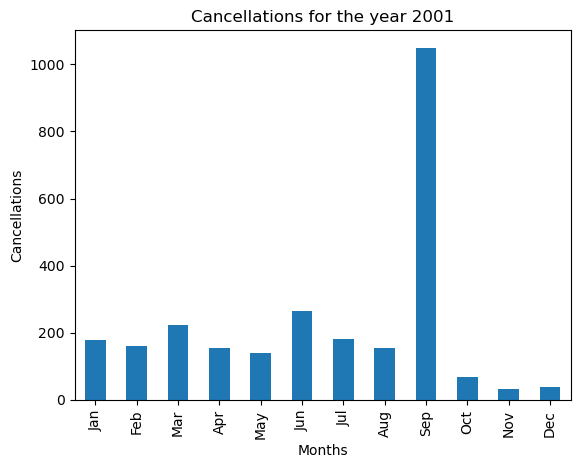

In [11]:
#Defined Function for bar graphs using dataframes.
#------------------------------------------------------------------------------------------------
def cancel(years):
    year = years["Year"].max()
    x_can = years.loc[(years['Cancelled'] == 1)]
    y_mon = x_can.groupby(['Month'])['Cancelled'].value_counts()
    y_mon = pd.DataFrame(y_mon)
    
    y_mon.plot.bar(color='tab:blue', legend=False)
    plt.xlabel("Months")
    plt.ylabel("Cancellations")
    x_axis = np.arange(12)
    
    plt.title(f"Cancellations for the year {year}")
    tick_locations = [value for value in x_axis]
    plt.xticks(tick_locations, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.show()
    return

cancel(year_2001)

In [25]:
year_2001

,Unnamed: 0_x,ActualElapsedTime,AirTime,Date,ArrDelay,ArrTime,CRSArrTime,CRSDepTime,CRSElapsedTime,CancellationCode,...,UniqueCarrier,WeatherDelay,Year,Unnamed: 0_y,Temperature,Precipitation,Rain Fall,Snow Fall,Amount of Snow,Weather
30,30,NaN,NaN,2001-09-17 00:00:00+00:00,NaN,NaN,2111,1915,116.0,NaN,...,DL,NaN,2001,14996.0,65.274650,0.000000,0.000000,0.0,0.0,Sunny
50,50,209.0,160.0,2001-11-25 15:00:00+00:00,29.0,1814.0,1745,1530,195.0,NaN,...,AA,NaN,2001,16667.0,56.058975,0.027559,0.027559,0.0,0.0,Drizzle
57,57,199.0,173.0,2001-12-24 08:00:00+00:00,-8.0,1058.0,1106,843,203.0,NaN,...,CO,NaN,2001,17356.0,36.170930,0.007874,0.007874,0.0,0.0,Light Drizzle
60,60,NaN,NaN,2001-09-13 00:00:00+00:00,NaN,NaN,1432,1335,117.0,NaN,...,UA,NaN,2001,14900.0,70.453350,0.000000,0.000000,0.0,0.0,Sunny
61,61,149.0,129.0,2001-05-06 13:00:00+00:00,-14.0,1505.0,1519,1340,159.0,NaN,...,NW,NaN,2001,11793.0,56.016610,0.000000,0.000000,0.0,0.0,Partly Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786284,786284,212.0,197.0,2001-11-08 12:00:00+00:00,-3.0,1346.0,1349,1215,214.0,NaN,...,UA,NaN,2001,16256.0,45.495663,0.000000,0.000000,0.0,0.0,Partly Cloudy
786317,786317,132.0,108.0,2001-11-29 09:00:00+00:00,-12.0,1150.0,1202,945,137.0,NaN,...,UA,NaN,2001,16757.0,54.692398,0.000000,0.000000,0.0,0.0,Cloudy
786336,786336,64.0,37.0,2001-06-20 23:00:00+00:00,101.0,24.0,2243,2145,58.0,NaN,...,UA,NaN,2001,12883.0,91.111570,0.000000,0.000000,0.0,0.0,Sunny
786343,786343,333.0,309.0,2001-06-20 09:00:00+00:00,-14.0,1138.0,1152,910,342.0,NaN,...,UA,NaN,2001,12869.0,67.935060,0.000000,0.000000,0.0,0.0,Sunny


In [ ]:
def compare(years):
    year = years["Cancellations"].max()
    x_can = years.loc[(years['Cancelled'] == 1)]
    y_mon = x_can.groupby(['Month'])['Cancelled'].value_counts()
    y_mon = pd.DataFrame(y_mon)
    
    y_mon.plot.bar(color='tab:blue', legend=False)
    plt.xlabel("Months")
    plt.ylabel("Cancellations")
    x_axis = np.arange(12)
    
    plt.title(f"Cancellations for the year {year}")
    tick_locations = [value for value in x_axis]
    plt.xticks(tick_locations, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.show()
    return